In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from  utils.common import NeuralNet, fit
import torch.optim as optim


/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


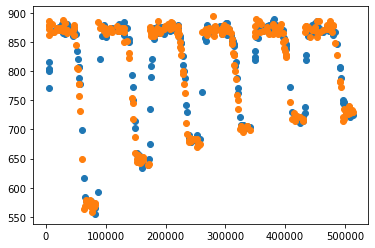

In [2]:
# Data loading and visualisation
train = pd.read_csv('Data/TrainingData_Task1.txt')
test = pd.read_csv('Data/TestingData_Task1.txt')
plt.scatter(train['t'], train['ts0'])
plt.scatter(train['t'], train['tf0'])

In [3]:
# Data preprocessing
train[train.select_dtypes(np.float64).columns] = train.select_dtypes(np.float64).astype(np.float32)
test[test.select_dtypes(np.float64).columns] = test.select_dtypes(np.float64).astype(np.float32)


scaler_t = MinMaxScaler()
scaler_ts0 = MinMaxScaler()
scaler_tf0 = MinMaxScaler()
scaler_t_test = MinMaxScaler()

t_train_scaled =  torch.tensor(scaler_t.fit_transform(train['t'].to_numpy().reshape(-1,1)))
t_train = torch.tensor(train['t'].to_numpy()).reshape(-1, 1)
ts0_scaled =  torch.tensor(scaler_ts0.fit_transform(train['ts0'].to_numpy().reshape(-1,1)))
ts0 = torch.tensor(train['ts0'].to_numpy()).reshape(-1, 1)
tf0_scaled = torch.tensor(scaler_tf0.fit_transform(train['tf0'].to_numpy().reshape(-1,1)))
tf0 = torch.tensor(train['tf0'].to_numpy()).reshape(-1, 1)
t_test_scaled = torch.tensor(scaler_t_test.fit_transform(test['t'].to_numpy().reshape(-1,1)))
t_test = torch.tensor(test['t'].to_numpy()).reshape(-1, 1)


In [4]:
# Define training set
n_samples = t_train.shape[0]
batch_size = t_train.shape[0]
sampling_seed = 78
torch.manual_seed(sampling_seed)
#Ts0
training_set_ts = DataLoader(torch.utils.data.TensorDataset(t_train_scaled, ts0_scaled), batch_size=n_samples, shuffle=True)
#Tf0
training_set_tf = DataLoader(torch.utils.data.TensorDataset(t_train_scaled, tf0_scaled), batch_size=n_samples, shuffle=True)

In [5]:
# Neural Network, parameters found by a grid search
NN_ts = NeuralNet(input_dimension=t_train.shape[1], output_dimension=ts0_scaled.shape[1], n_hidden_layers=10, neurons=40, regularization_param = 1e-5,regularization_exp = 2, retrain_seed = 128)
NN_tf = NeuralNet(input_dimension=t_train.shape[1], output_dimension=tf0_scaled.shape[1], n_hidden_layers=10, neurons=35, regularization_param = 1e-5,regularization_exp = 2, retrain_seed = 128)


# Chose the optimizer
# Type of optimizer (ADAM (1st order method) or LBFGS (2nd order method))
opt_type = "ADAM"
if opt_type == "ADAM":
    optimizer_ts = optim.Adam(NN_ts.parameters(), lr=0.005, weight_decay=1e-5) # lr = learning rate
    optimizer_tf = optim.Adam(NN_tf.parameters(), lr=0.005, weight_decay=1e-5) # lr = learning rate
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(NN_ts.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")
n_epochs_ts = 8000
n_epochs_tf = 14000

In [7]:
# Training
history_ts = fit(NN_ts, training_set_ts, optimizer = optimizer_ts, p=2, verbose=False, num_epochs = n_epochs_ts)
history_tf = fit(NN_tf, training_set_tf, optimizer = optimizer_tf, p=2, verbose=False, num_epochs = n_epochs_tf)

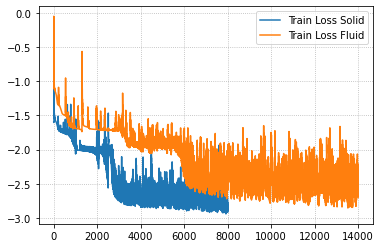

In [8]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs_ts+1), np.log10(history_ts), label="Train Loss Solid")
plt.legend()

plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs_tf+1), np.log10(history_tf), label="Train Loss Fluid")
plt.legend()

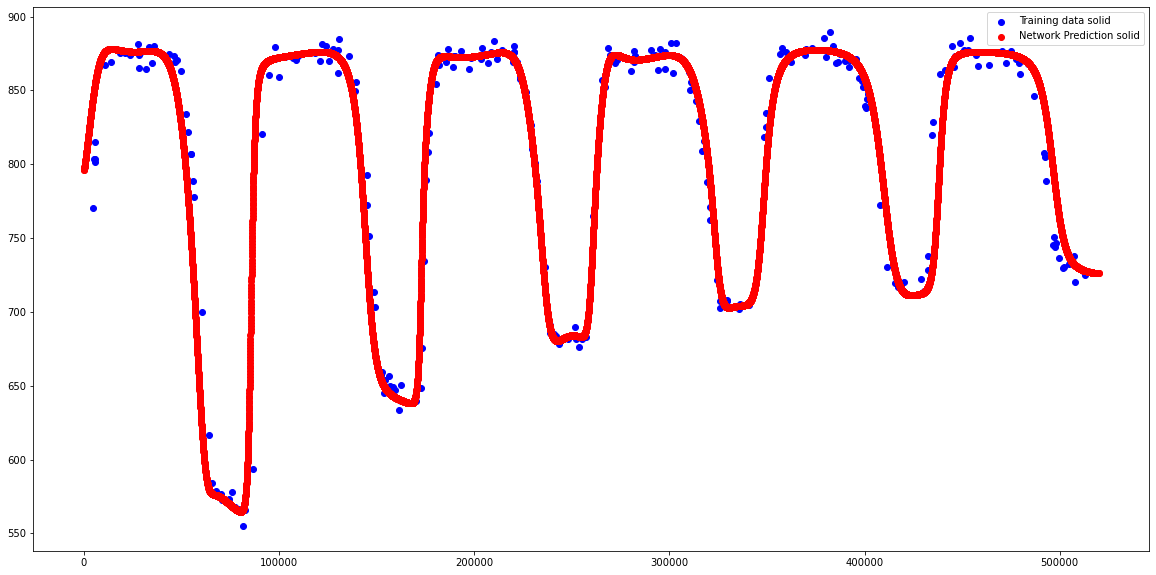

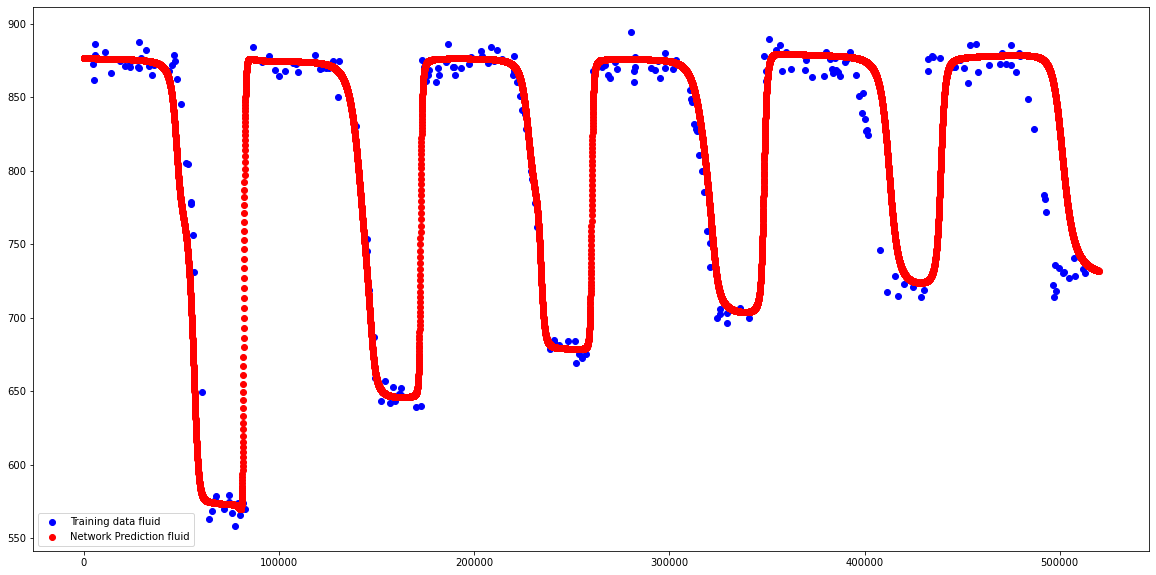

In [9]:
# Prediction
with torch.no_grad():
    pred_ts_scaled = NN_ts(t_test_scaled).reshape(-1,)
    pred_tf_scaled = NN_tf(t_test_scaled).reshape(-1,)


pred_ts = scaler_ts0.inverse_transform(pred_ts_scaled.reshape(-1, 1))
pred_tf = scaler_tf0.inverse_transform(pred_tf_scaled.reshape(-1, 1))

plt.figure(figsize=(20, 10))
plt.scatter(t_train, ts0, label= "Training data solid", marker="o", color = 'blue')
plt.scatter(t_test, pred_ts, label="Network Prediction solid",marker="o", color = 'red')
plt.legend()

plt.figure(figsize=(20, 10))
plt.scatter(t_train, tf0, label= "Training data fluid", marker="o", color = 'blue')
plt.scatter(t_test, pred_tf, label="Network Prediction fluid",marker="o", color = 'red')
plt.legend()